In [66]:
import pandas as pd
import os
import numpy as np
from dotenv import load_dotenv
import ast
import glob


load_dotenv()

data_folder = os.getenv("DATA_FOLDER")

file_prefix = 'label_data'

# Use glob to find all CSV files with the given filename start
file_list = glob.glob(f"{data_folder}/{file_prefix}*.csv")

# Read each file into a DataFrame and concatenate them into a single DataFrame
dataframes = [pd.read_csv(file, sep=";",index_col=0) for file in file_list]
df = pd.concat(dataframes, ignore_index=True)

In [67]:
faulty_labels = 0
def safe_literal_eval(x):
    global faulty_labels
    try:
        return ast.literal_eval(x)
    except:
        faulty_labels += 1

df['Labels'] = df['Labels'].apply(safe_literal_eval)
print(faulty_labels)

101


In [68]:
df = df[df['Labels'].notna()]

In [69]:
# placeholder_ng_score = df['avg_score'].median()
# placeholder_ng_score

In [ ]:
df.groupby('Category')['avg_score'].describe() # 

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,368.0,86.641955,14.599342,15.555556,85.000000,92.083333,95.0000,100.0
True,330.0,85.077213,15.746573,5.000000,83.517857,90.217857,94.1125,100.0


In [70]:
def retrieve_params(label_dict_list, positions=False, headlines=False):
    #create three distinct lists to control each parameter
    # if label_dict_list is empty return NaN
    if not label_dict_list:
        return np.nan
    article_stances = []
    article_ng_scores = []
    article_serp_positions = []
    
    for article in label_dict_list: #this is the search level; here we can retrieve SERP position and Newsguard score
        if not article: #catch empty entries
            continue
        if len(article['comparisons']) == 0:
               continue
        #retrieve variables
        serp_newsguard = article['serp_newsguard']
        serp_position = article['serp_position']

        #add to lists for decomposed calculation
        article_ng_scores.append(serp_newsguard)
        article_serp_positions.append(serp_position)

        article_stance = 0
        for claim_pair in article['comparisons']: #this is the "article level"; here we can retrieve relative claim position and the bool headline info
            relation = claim_pair['relation']

            if relation == 0: #skip unrelated claims
                continue

            try:
                #retrieve relative claim positions
                fm_claim_position = claim_pair['fm_claim_position']
                serp_claim_position = claim_pair['serp_claim_position']

                #retrieve headline bool
                fm_claim_headline = claim_pair['fm_claim_headline']
                serp_claim_headline = claim_pair['serp_claim_headline']

            except:
                pass

            if not positions and not headlines: #calculate article stance only based on relation
                article_stance += relation
            if positions and not headlines: #calculate article stance based on relation and position
                article_stance += relation * (serp_claim_position - fm_claim_position)
            if headlines and not positions:
                article_stance += relation * serp_claim_headline - fm_claim_headline

        article_stances.append(article_stance/len(article['comparisons']))

    #if article_stances could not be successfully retrieved, return NaN
    if not article_stances:
        return np.nan
    
    article_ng_scores = np.array(article_ng_scores, dtype=float)
    # article_ng_scores = np.nan_to_num(article_ng_scores, nan=placeholder_ng_score) 

    return {'article_stances': article_stances, 'article_ng_scores': article_ng_scores, 'article_serp_positions': article_serp_positions}

In [71]:
df['Features_Raw']= df['Labels'].apply(retrieve_params)
df['Features_Pos']= df['Labels'].apply(lambda x: retrieve_params(x, positions=True, headlines=False))
df['Features_H']= df['Labels'].apply(lambda x: retrieve_params(x, positions=False, headlines=True))

# Additional Features for Exploration

Number of articles

In [72]:
label_mapping = {
    'Coul' : np.nan,
    'Misl' : 0,
    'True' : 1
}

df['User_Labels'] = df['Category'].map(label_mapping)

In [73]:
df = df[df['User_Labels'].notna()] #remove 'could' values

In [74]:
def get_num_articles(label_lists):
    return sum(bool(d) for d in label_lists)

df['num_valid_articles'] = df['Labels'].apply(get_num_articles)

In [75]:
df['num_valid_articles'].describe()

count    728.000000
mean       2.657967
std        2.014334
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max        9.000000
Name: num_valid_articles, dtype: float64

Transform Labels into 1-0; disregarding 'Could not determine'

In [76]:
df.groupby('Category')['num_valid_articles'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,385.0,2.532468,2.005100,0.0,1.0,2.0,4.0,8.0
True,343.0,2.798834,2.018279,0.0,1.0,3.0,4.0,9.0


# Article Stances

## Raw Stances

In [77]:
#try different transformation methods

def transform_stances(feat_dict, method):
    if pd.isna(feat_dict):
        return np.nan
    stance_list = feat_dict['article_stances']
    return method(stance_list)

### Mean

In [78]:
df['Stances_Mean'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=np.mean))

In [79]:
df['Stances_Mean'].describe()

count    595.000000
mean       0.106813
std        0.253608
min       -1.000000
25%       -0.018000
50%        0.080000
75%        0.266667
max        1.000000
Name: Stances_Mean, dtype: float64

In [80]:
df.groupby('Category')['Stances_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,300.0,0.075238,0.236799,-0.866667,-0.048,0.026667,0.20,0.76
True,295.0,0.138922,0.266209,-1.000000,0.000,0.128000,0.32,1.00


In [81]:
df.groupby('num_valid_articles')['Stances_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,105.0,0.147429,0.351888,-1.000000,0.000000,0.120000,0.440000,1.000000
2,137.0,0.113066,0.279699,-1.000000,0.000000,0.080000,0.320000,0.720000
3,114.0,0.101519,0.224328,-0.866667,-0.010000,0.080000,0.266667,0.520000
4,97.0,0.061874,0.169322,-0.450000,-0.040000,0.053333,0.170000,0.470000
5,67.0,0.109761,0.177236,-0.272000,-0.028000,0.112000,0.232000,0.544000
6,50.0,0.081053,0.224124,-0.460000,-0.083333,0.033333,0.240000,0.560000
7,17.0,0.098936,0.240454,-0.342857,-0.005714,0.057143,0.333333,0.422857
8,6.0,0.305929,0.154284,0.135000,0.170144,0.312788,0.406250,0.515000


C:\Users\danie\AppData\Local\Temp\ipykernel_14536\2511394612.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_Mean', palette='Set1')


Text(0, 0.5, 'Stances Mean')

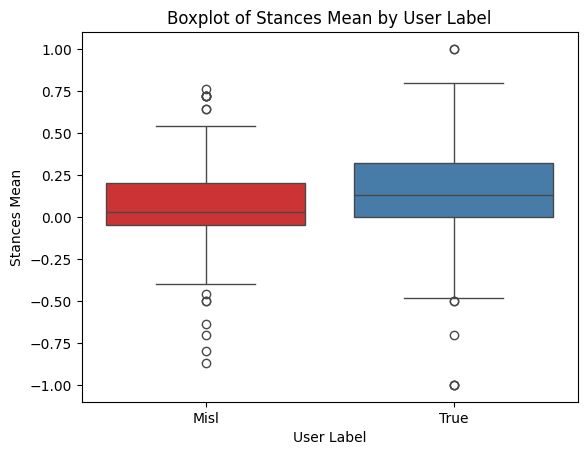

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df, x='Category', y='Stances_Mean', palette='Set1')
plt.title('Boxplot of Stances Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

#### Last User Queries

In [83]:
last_search_df = df.drop_duplicates(subset='ResponseId', keep='last')
last_search_df.groupby('Category')['Stances_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,111.0,0.065052,0.238955,-0.866667,-0.063333,0.04,0.200000,0.72
True,130.0,0.150607,0.287715,-1.000000,0.000000,0.13,0.356667,1.00


C:\Users\danie\AppData\Local\Temp\ipykernel_14536\3509361157.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=last_search_df, x='Category', y='Stances_Mean', palette='Set1')


Text(0, 0.5, 'Stances Mean')

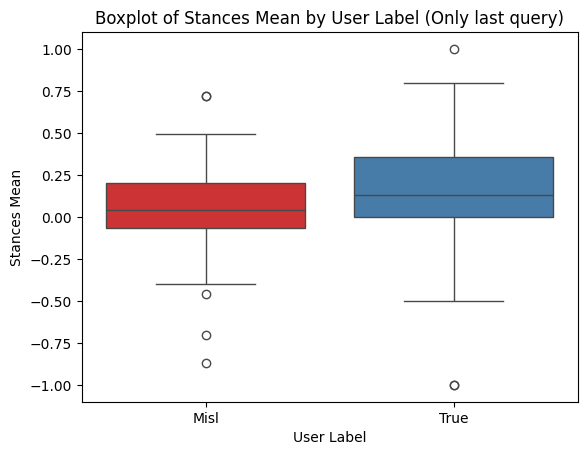

In [84]:
sns.boxplot(data=last_search_df, x='Category', y='Stances_Mean', palette='Set1')
plt.title('Boxplot of Stances Mean by User Label (Only last query)')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

### NDCG

In [85]:
from sklearn.metrics import ndcg_score

In [86]:
test_array = [0.5, 0.01, 0.3, -1, 1]

#transform values to fit between 0 and 1

def ndcg(stances):
    stances = np.array(stances)
    stances = (stances + 1) / 2  # Transform values from [-1, 1] to [0, 1]
    if len(stances) == 1:
        return np.nan
    true_relevance = np.array([stances])  
    relevance_score = np.array([sorted(stances, reverse=True)]) 

    return ndcg_score(true_relevance, relevance_score)
          
ndcg(test_array)

np.float64(0.883307074205988)

In [87]:
df['Stances_NDCG'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=ndcg))

In [88]:
df['Stances_NDCG'].describe()

count    481.000000
mean       0.962825
std        0.049394
min        0.630930
25%        0.942639
50%        0.979165
75%        1.000000
max        1.000000
Name: Stances_NDCG, dtype: float64

In [89]:
df.groupby('Category')['Stances_NDCG'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,243.0,0.962708,0.049040,0.63093,0.943011,0.981516,1.0,1.0
True,238.0,0.962944,0.049857,0.63093,0.942651,0.976208,1.0,1.0


In [90]:
df.groupby('num_valid_articles')['Stances_NDCG'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,128.0,0.978547,0.053396,0.630930,0.972465,1.000000,1.000000,1.000000
3,114.0,0.967973,0.048339,0.704431,0.952796,0.982022,1.000000,1.000000
4,97.0,0.960410,0.041277,0.768858,0.932317,0.975230,0.995061,1.000000
5,67.0,0.946564,0.051165,0.692736,0.929165,0.952884,0.983033,1.000000
6,50.0,0.948721,0.043370,0.805914,0.936017,0.955702,0.978902,1.000000
7,17.0,0.934183,0.044122,0.849172,0.911346,0.937351,0.961544,0.995230
8,6.0,0.959450,0.034678,0.915757,0.930386,0.969431,0.980891,1.000000


C:\Users\danie\AppData\Local\Temp\ipykernel_14536\1980220825.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='num_valid_articles', y='Stances_NDCG', palette='Set1')


Text(0, 0.5, 'Stances Mean')

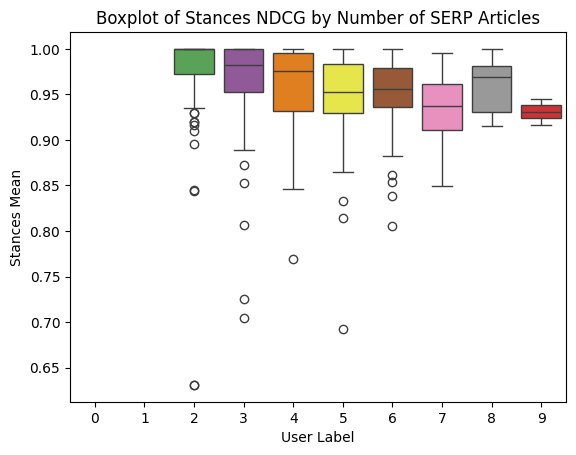

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df, x='num_valid_articles', y='Stances_NDCG', palette='Set1')
plt.title('Boxplot of Stances NDCG by Number of SERP Articles')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

### First Entry

In [146]:
def retrieve_serp_results(feat_dict, position=1):
    if pd.isna(feat_dict):
        return np.nan
    
    stance_list = feat_dict['article_stances']
    serp_positions = feat_dict['article_serp_positions']
    
    if isinstance(position, list):
        results = [np.mean(stance_list[serp_positions.index(pos)]) for pos in position if pos in serp_positions]
        return np.nan if not results else np.mean(results)
    elif position in serp_positions:
        return np.mean(stance_list[serp_positions.index(position)])
    
    return np.nan

In [ ]:
df['Stances_First'] = df['Features_Raw'].apply(lambda x: retrieve_serp_results(x, position=[1,2,3]))

In [148]:
df.groupby('Category')['Stances_First'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,170.0,0.083637,0.272911,-1.0,-0.02,0.01,0.22,0.84
True,186.0,0.166022,0.325025,-1.0,0.00,0.20,0.40,1.00


C:\Users\danie\AppData\Local\Temp\ipykernel_14536\94648427.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_First', palette='Set1')


Text(0, 0.5, 'Stances Mean')

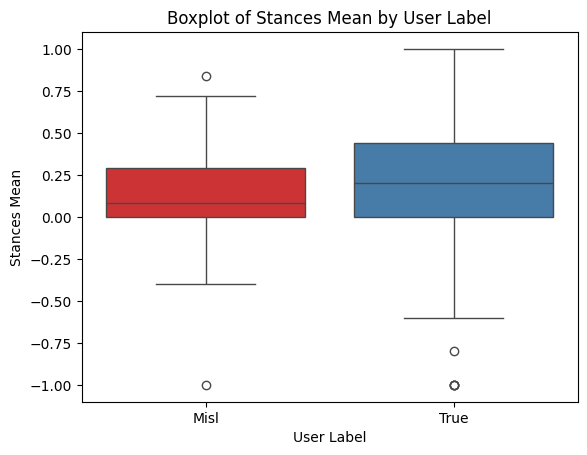

In [134]:
sns.boxplot(data=df, x='Category', y='Stances_First', palette='Set1')
plt.title('Boxplot of Stances Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

### Median

In [92]:
df['Stances_Median'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=np.median))

In [93]:
df['Stances_Median'].describe()

count    595.000000
mean       0.106918
std        0.248738
min       -1.000000
25%        0.000000
50%        0.080000
75%        0.260000
max        1.000000
Name: Stances_Median, dtype: float64

In [94]:
df.groupby('Category')['Stances_Median'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,300.0,0.074843,0.236080,-0.8,-0.02,0.00,0.20,0.76
True,295.0,0.139537,0.257302,-1.0,0.00,0.12,0.31,1.00


In [95]:
df.groupby('num_valid_articles')['Stances_Median'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,105.0,0.147429,0.351888,-1.00,0.00,0.12,0.440000,1.00
2,137.0,0.113066,0.279699,-1.00,0.00,0.08,0.320000,0.72
3,114.0,0.102398,0.209916,-0.80,0.00,0.08,0.266667,0.48
4,97.0,0.051782,0.159106,-0.30,-0.02,0.02,0.140000,0.46
5,67.0,0.113731,0.158982,-0.32,0.00,0.08,0.200000,0.56
6,50.0,0.088600,0.221147,-0.48,-0.04,0.02,0.220000,0.62
7,17.0,0.121176,0.226326,-0.40,0.00,0.04,0.300000,0.48
8,6.0,0.313333,0.171425,0.08,0.20,0.32,0.425000,0.54


C:\Users\danie\AppData\Local\Temp\ipykernel_14536\2000799094.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_Median', palette='Set1')


Text(0, 0.5, 'Stances Median')

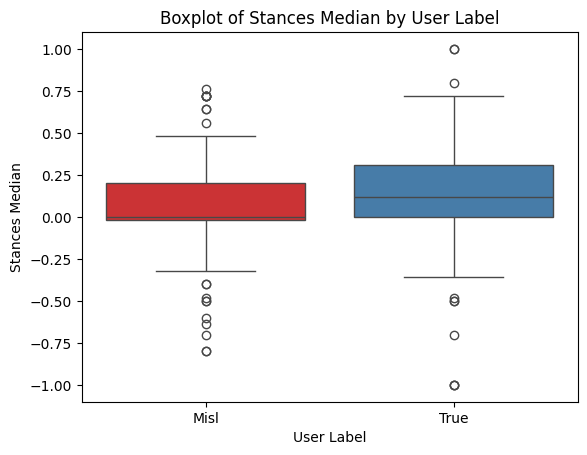

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df, x='Category', y='Stances_Median', palette='Set1')
plt.title('Boxplot of Stances Median by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Median')

## Stances w/ Positions

### Mean

In [97]:
df['Stances_Pos_Mean'] = df['Features_Pos'].apply(lambda x: transform_stances(x, method=np.mean))

In [98]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Stances_Pos_Mean'] = scaler.fit_transform(np.array(df['Stances_Pos_Mean']).reshape(-1, 1)).flatten()

In [99]:
df['Stances_Pos_Mean'].describe()

count    595.000000
mean       0.053302
std        0.192307
min       -1.000000
25%       -0.020967
50%        0.065684
75%        0.129508
max        1.000000
Name: Stances_Pos_Mean, dtype: float64

In [100]:
df.groupby('Category')['Stances_Pos_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,300.0,0.087598,0.163239,-0.788395,0.007023,0.065684,0.134138,0.793387
True,295.0,0.018424,0.212598,-1.000000,-0.067656,0.065684,0.125443,1.000000


In [101]:
df.groupby('num_valid_articles')['Stances_Pos_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,105.0,0.060084,0.259946,-1.000000,0.003186,0.065684,0.093834,1.000000
2,137.0,0.076881,0.167095,-0.509743,-0.031067,0.065684,0.175873,0.505496
3,114.0,0.076093,0.146313,-0.357229,-0.000466,0.065684,0.141797,0.444353
4,97.0,0.044864,0.118753,-0.406949,-0.021071,0.065684,0.105494,0.334732
5,67.0,0.093229,0.203224,-0.434496,-0.007622,0.090171,0.185430,0.568609
6,50.0,-0.033024,0.207808,-0.554653,-0.130489,0.006009,0.081217,0.405494
7,17.0,-0.068560,0.215002,-0.489729,-0.109166,0.020282,0.075713,0.218439
8,6.0,-0.273934,0.230178,-0.490811,-0.459300,-0.338502,-0.114993,0.064266


C:\Users\danie\AppData\Local\Temp\ipykernel_14536\4211040222.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_Pos_Mean', palette='Set1')


Text(0, 0.5, 'Stances Mean')

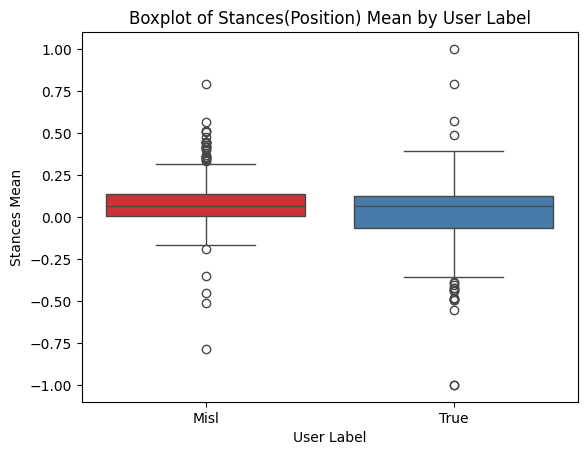

In [102]:
sns.boxplot(data=df, x='Category', y='Stances_Pos_Mean', palette='Set1')
plt.title('Boxplot of Stances(Position) Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

In [103]:
last_search_df = df.drop_duplicates(subset='ResponseId', keep='last')
last_search_df.groupby('Category')['Stances_Pos_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,111.0,0.085380,0.141749,-0.354296,0.002147,0.065684,0.143767,0.474163
True,130.0,0.008458,0.244733,-1.000000,-0.120077,0.055158,0.116129,1.000000


## Stances w/ Headlines

### Mean

In [104]:
df['Stances_H_Mean'] = df['Features_H'].apply(lambda x: transform_stances(x, method=np.mean))

In [105]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Stances_H_Mean'] = scaler.fit_transform(np.array(df['Stances_H_Mean']).reshape(-1, 1)).flatten()

In [106]:
df['Stances_H_Mean'].describe()

count    595.000000
mean      -0.456098
std        0.140642
min       -1.000000
25%       -0.514286
50%       -0.428571
75%       -0.428571
max        1.000000
Name: Stances_H_Mean, dtype: float64

In [107]:
df.groupby('Category')['Stances_H_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,300.0,-0.458376,0.120620,-1.000000,-0.500000,-0.428571,-0.428571,0.314286
True,295.0,-0.453782,0.158608,-0.857143,-0.532381,-0.428571,-0.428571,1.000000


In [108]:
df.groupby('num_valid_articles')['Stances_H_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,105.0,-0.443810,0.235908,-0.828571,-0.485714,-0.428571,-0.428571,1.000000
2,137.0,-0.446715,0.135786,-0.857143,-0.514286,-0.428571,-0.428571,0.314286
3,114.0,-0.473352,0.083766,-0.771429,-0.519048,-0.428571,-0.428571,-0.352381
4,97.0,-0.456198,0.110098,-0.700000,-0.528571,-0.442857,-0.414286,-0.071429
5,67.0,-0.456787,0.081966,-0.657143,-0.520000,-0.428571,-0.395238,-0.268571
6,50.0,-0.478857,0.125135,-1.000000,-0.550000,-0.428571,-0.383333,-0.342857
7,17.0,-0.454582,0.095674,-0.648980,-0.526531,-0.428571,-0.387755,-0.346939
8,6.0,-0.367857,0.025455,-0.392857,-0.383929,-0.371429,-0.364286,-0.321429


C:\Users\danie\AppData\Local\Temp\ipykernel_14536\3702187806.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_H_Mean', palette='Set1')


Text(0, 0.5, 'Stances Mean')

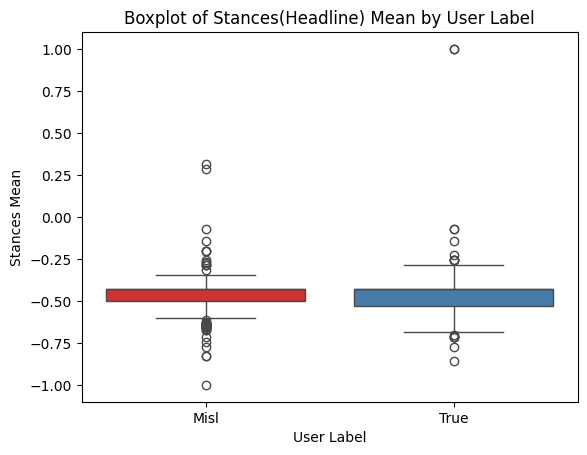

In [109]:
sns.boxplot(data=df, x='Category', y='Stances_H_Mean', palette='Set1')
plt.title('Boxplot of Stances(Headline) Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

## Newsguard Score

In [110]:
def transform_newsguard(feat_dict, method):
    if pd.isna(feat_dict):
        return np.nan
    article_ng_scores = feat_dict['article_ng_scores']
    article_ng_scores = np.nan_to_num(article_ng_scores, nan=0)
    return method(article_ng_scores)

In [111]:
df['Newsguard_Mean'] = df['Features_Raw'].apply(lambda x: transform_newsguard(x, method=np.mean))

In [112]:
df.groupby('Category')['Newsguard_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,300.0,61.688486,36.452892,0.0,36.062500,74.000,92.589286,100.0
True,295.0,59.120817,35.840679,0.0,33.333333,67.375,91.414286,100.0


C:\Users\danie\AppData\Local\Temp\ipykernel_14536\3465771059.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Newsguard_Mean', palette='Set2')


Text(0, 0.5, 'NG Mean')

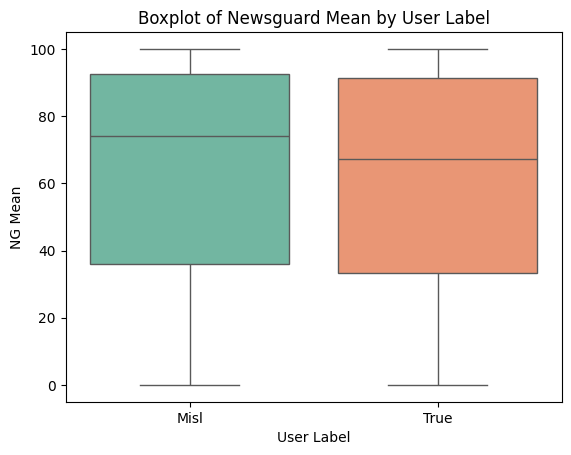

In [113]:
sns.boxplot(data=df, x='Category', y='Newsguard_Mean', palette='Set2')
plt.title('Boxplot of Newsguard Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('NG Mean')

# Article SERP Position

## Mean Rank

In [114]:
def transform_serp_position(feat_dict, method):
    if pd.isna(feat_dict):
        return np.nan
    article_serp_positions = feat_dict['article_serp_positions']
    article_serp_positions = np.nan_to_num(article_serp_positions, nan=0)
    return method(article_serp_positions)

In [115]:
df['SERP_Position_Mean'] = df['Features_Raw'].apply(lambda x: transform_serp_position(x, method=np.mean))

In [116]:
df.groupby('Category')['SERP_Position_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,300.0,5.211726,1.955638,1.0,4.0,5.0,6.333333,10.0
True,295.0,4.916636,1.976339,1.0,3.9,5.0,6.166667,9.5


C:\Users\danie\AppData\Local\Temp\ipykernel_14536\3667827325.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='SERP_Position_Mean', palette='Set3')


Text(0, 0.5, 'NG Mean')

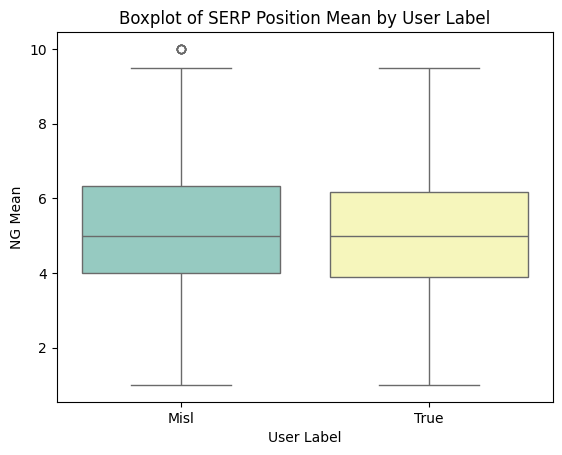

In [117]:
sns.boxplot(data=df, x='Category', y='SERP_Position_Mean', palette='Set3')
plt.title('Boxplot of SERP Position Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('NG Mean')

## Mean Reciprocal Rank

In [118]:
def reciprocal_rank(serp_positions):
    if pd.isna(serp_positions):
        return np.nan
    return 1/serp_positions[0]

In [119]:
df['SERP_Position_ReciprocalRank'] = df['Features_Raw'].apply(lambda x: transform_serp_position(x, method=reciprocal_rank))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()